# **TDP Final Project** - Wavelets:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sdas.tests.LoadSdasData import LoadSdasData
from sdas.tests.StartSdas import StartSdas

import pywt

plt.style.use('bmh')

In [3]:
# Load and select data
shot = 35057
client = StartSdas()

d={} # Empty dictionary: Reading data for all 'good' coils.
for x in range(2,13): # For looping 
    if(x<10):
        d["Coil{0}".format(x)]= LoadSdasData(client, "PCIE_ATCA_ADC_16.BOARD_2.CHANNEL_00{0}".format(x), shot)
    elif(x!=11):
        d["Coil{0}".format(x)]= LoadSdasData(client, "PCIE_ATCA_ADC_16.BOARD_2.CHANNEL_0{0}".format(x), shot)

# d['Coil{x}'][0] -> '$dB_{\theta}/dt$ (a.u.)'
# d['Coil{x}'][1] -> Time

In [4]:
import matplotlib.ticker as ticker

In [5]:
fs = float(1/(d['Coil2'][1][1] - d['Coil2'][1][0])*1e6)
NFFT = 2048 # Number of points used in FFT calculation.
Delta_t = 1/fs
Delta_T = NFFT * Delta_t
Delta_f = 1/Delta_T

print(f' NFFT = {NFFT}, fs = {fs}, Delta_t = {Delta_t} s, Delta_T = {Delta_T} s, Delta_f = {Delta_f} Hz.')

 NFFT = 2048, fs = 2000000.0, Delta_t = 5e-07 s, Delta_T = 0.001024 s, Delta_f = 976.5625 Hz.


(1025, 312) (1025,) (312,)


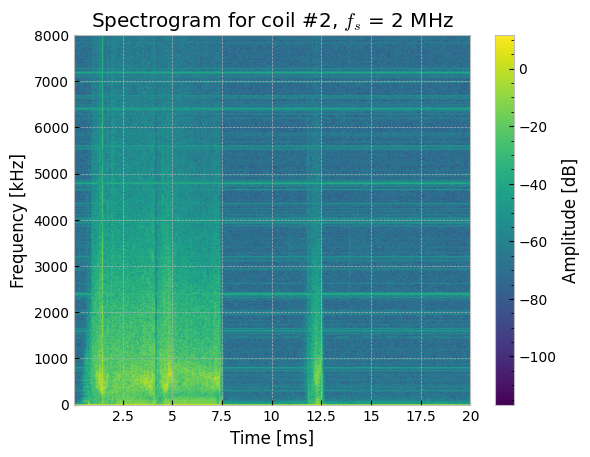

In [36]:
# Setup figures

# This property is related to the Heisenberg uncertainty principle, but not directly – see Gabor limit for discussion.
# The product of the standard deviation in time and frequency is limited. The boundary of the uncertainty principle 
# (best simultaneous resolution of both) is reached with a Gaussian window function (or mask function), as the Gaussian
#  minimizes the Fourier uncertainty principle. This is called the Gabor transform (and with modifications for multiresolution 
# becomes the Morlet wavelet transform).

fig, ax1 = plt.subplots()

Pxx, freqs, bins, im = plt.specgram(d['Coil2'][0], NFFT=NFFT, Fs=fs*8, noverlap=int (NFFT/2))
# This uses STFT: Short-Time Fourier Transform.

# Debugging:
print(Pxx.shape, freqs.shape, bins.shape)

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()
plt.title(r'Spectrogram for coil #2, $f_{s}$' + f' = {fs * 1e-6:.0f} MHz')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [ms]')

scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax1.yaxis.set_major_formatter(ticks_y)

scale_x = 1e-3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax1.xaxis.set_major_formatter(ticks_x)

# plt.axis((45e-3, 50e-3, 0, 200e3)) # Chosen interval!
# plt.savefig('Coil2_Spectrogram.svg', format = 'svg')
plt.show()


In [7]:
# Discrete Wavelet Transform (DWT):
x = d['Coil2'][0]
cA, cD = pywt.dwt(x, 'db2')

# Continuous Wavelet Transform (CWT):
widths = np.arange(1,250)
coef, freqs = pywt.cwt(x, widths,'morl')

print(coef.shape)
print(freqs.shape)

(249, 320512)
(249,)


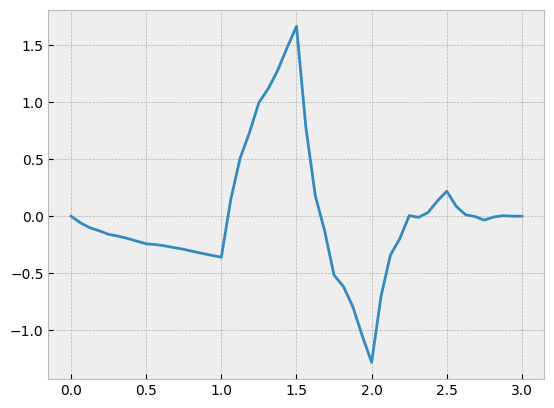

In [8]:
[phi, psi, x] = pywt.Wavelet('db2').wavefun(level=4)
plt.plot(x, psi)
plt.show()

In [9]:
def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor1.5-1.0', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
    cbar.minorticks_on()

    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(frequencies.min())), np.ceil(np.log2(frequencies.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim

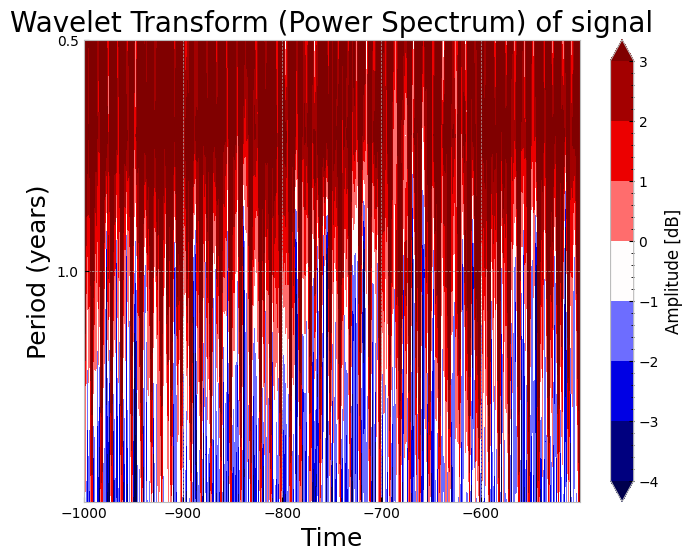

In [10]:
scales = np.arange(1, 128)
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (years)'
xlabel = 'Time'

fig, ax = plt.subplots(figsize=(8, 6))
plot_wavelet(ax, d['Coil2'][1][:1000], d['Coil2'][0][:1000], scales, xlabel=xlabel, ylabel=ylabel, title=title)
plt.show()

In [11]:
def my_plot_wavelet(ax, time, signal, scales, waveletname = 'cmor1.5-1.0', 
                    cmap = plt.cm.viridis, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = coefficients
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, frequencies, power, contourlevels, extend='both',cmap=cmap)
    print(frequencies)
    print(np.log2(frequencies))

    cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
    cbar.minorticks_on()

    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    scale_x = 1e+3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
    ax.xaxis.set_major_formatter(ticks_x)

    # yticks = 2**np.arange(np.ceil(np.log2(frequencies.min())), np.ceil(np.log2(frequencies.max())))
    # ax.set_yticks(np.log2(yticks))
    # ax.set_yticklabels(yticks)
    # ax.invert_yaxis()
    # ylim = ax.get_ylim()
    # ax.set_ylim(ylim[0], -1)
    return 0

d:\Pastas úteis\Uni\MEFT\Ano1_P1\TDP\TDP_venv\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


[2.         1.         0.66666667 0.5        0.4        0.33333333
 0.28571429 0.25       0.22222222 0.2        0.18181818 0.16666667
 0.15384615 0.14285714 0.13333333 0.125      0.11764706 0.11111111
 0.10526316 0.1        0.0952381  0.09090909 0.08695652 0.08333333
 0.08       0.07692308 0.07407407 0.07142857 0.06896552 0.06666667
 0.06451613 0.0625     0.06060606 0.05882353 0.05714286 0.05555556
 0.05405405 0.05263158 0.05128205 0.05       0.04878049 0.04761905
 0.04651163 0.04545455 0.04444444 0.04347826 0.04255319 0.04166667
 0.04081633 0.04       0.03921569 0.03846154 0.03773585 0.03703704
 0.03636364 0.03571429 0.03508772 0.03448276 0.03389831 0.03333333
 0.03278689 0.03225806 0.03174603 0.03125    0.03076923 0.03030303
 0.02985075 0.02941176 0.02898551 0.02857143 0.02816901 0.02777778
 0.02739726 0.02702703 0.02666667 0.02631579 0.02597403 0.02564103
 0.02531646 0.025      0.02469136 0.02439024 0.02409639 0.02380952
 0.02352941 0.02325581 0.02298851 0.02272727 0.02247191 0.0222

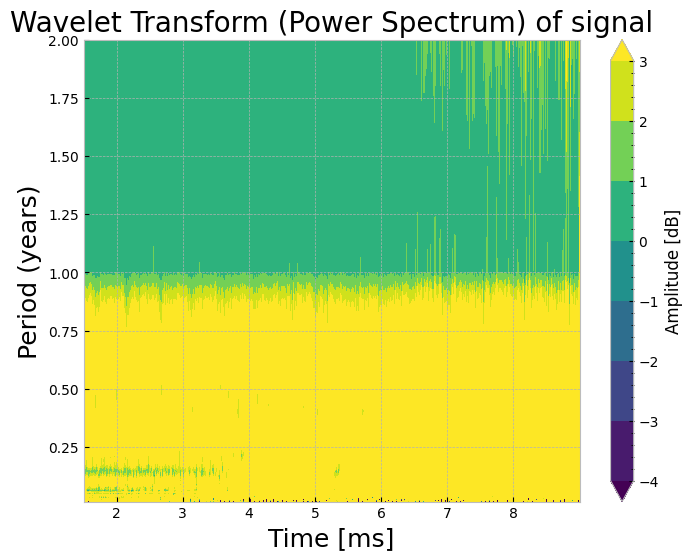

In [12]:
scales = np.arange(1, 128)
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (years)'
xlabel = 'Time [ms]'

fig, ax = plt.subplots(figsize=(8, 6))
my_plot_wavelet(ax, d['Coil2'][1][5000:20000], d['Coil2'][0][5000:20000], scales, xlabel=xlabel, ylabel=ylabel, title=title)
plt.show()

In [13]:
t = d['Coil2'][1]
sig  = d['Coil2'][0]
widths = np.linspace(1000, 1000e3, 1000, endpoint=True)
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
plt.imshow(cwtmatr, extent=[d['Coil2'][1][0], d['Coil2'][1][-1], 1000, 1000e3], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  
plt.show()

KeyboardInterrupt: 

In [ ]:
np.linspace(1000, 1000e3, 1000, endpoint=True)


array([   1000.,    2000.,    3000.,    4000.,    5000.,    6000.,
          7000.,    8000.,    9000.,   10000.,   11000.,   12000.,
         13000.,   14000.,   15000.,   16000.,   17000.,   18000.,
         19000.,   20000.,   21000.,   22000.,   23000.,   24000.,
         25000.,   26000.,   27000.,   28000.,   29000.,   30000.,
         31000.,   32000.,   33000.,   34000.,   35000.,   36000.,
         37000.,   38000.,   39000.,   40000.,   41000.,   42000.,
         43000.,   44000.,   45000.,   46000.,   47000.,   48000.,
         49000.,   50000.,   51000.,   52000.,   53000.,   54000.,
         55000.,   56000.,   57000.,   58000.,   59000.,   60000.,
         61000.,   62000.,   63000.,   64000.,   65000.,   66000.,
         67000.,   68000.,   69000.,   70000.,   71000.,   72000.,
         73000.,   74000.,   75000.,   76000.,   77000.,   78000.,
         79000.,   80000.,   81000.,   82000.,   83000.,   84000.,
         85000.,   86000.,   87000.,   88000.,   89000.,   900

[[-0.        +0.j         -0.        +0.j         -0.        +0.j
  ... -0.        +0.j         -0.        +0.j
  -0.        +0.j        ]
 [-0.        +0.j         -0.        +0.j         -0.        +0.j
  ... -0.        +0.j         -0.        +0.j
  -0.        +0.j        ]
 [-0.        +0.j         -0.        +0.j         -0.        +0.j
  ... -0.        +0.j         -0.        +0.j
  -0.        +0.j        ]
 ...
 [ 0.18808129+0.63187295j  0.16781004+0.65039378j  0.15242329+0.66311264j
  ...  0.1041699 +0.41210246j  0.08663643+0.43045147j
   0.07169322+0.44529076j]
 [ 0.18817328+0.63218201j  0.16789212+0.65071189j  0.15249785+0.66343698j
  ...  0.12407944+0.39077095j  0.10422085+0.41230403j
   0.0866788 +0.43066201j]
 [ 0.16797416+0.65102986j  0.15257236+0.66376116j  0.14197324+0.67078122j
  ...  0.12414007+0.3909619j   0.10427178+0.41250549j
   0.08672116+0.43087245j]]
(1024, 1024)
[1.00000000e+00 5.00000000e-01 3.33333333e-01 ... 9.78473581e-04
 9.77517107e-04 9.76562500e-04]


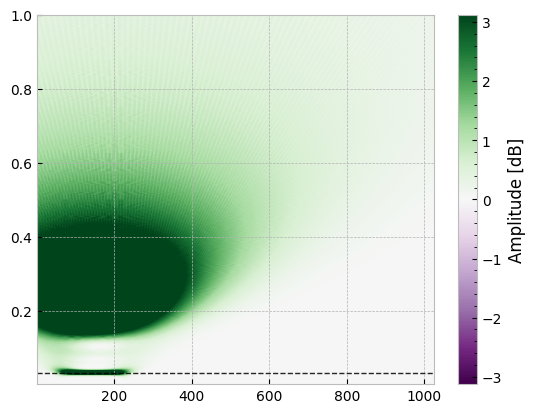

In [14]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(512*2)
y = np.sin(2*np.pi*x/32) + np.sin(2*np.pi*x/256)
for i in range(0, len(y)):
    if(i > 50 and i< 225):
        1
    else:
        y[i]=0
# plt.plot(x,y)

coef, freqs=pywt.cwt(y,np.arange(1,512*2+1),'cmor1.5-1.0') # These frequencies are in Hertz!!!!!!!!
power = (abs(coef)) ** 2
im = plt.imshow(power, extent=[1, 512*2, 1/(512*2+1), 1], cmap='PRGn', aspect='auto',
           vmax=abs(coef).max(), vmin=-abs(coef).max(), origin='lower') 
print(coef)
print(coef.shape)
print(freqs)
cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()
plt.axhline(y=1/32, linestyle = 'dashed', linewidth=1, color='black', alpha=0.85) #adds black line @ y=0 Cut-off density!
plt.show() 



[[-0.        +0.j         -0.        +0.j         -0.        +0.j
  ... -0.        +0.j         -0.        +0.j
  -0.        +0.j        ]
 [-0.        +0.j         -0.        +0.j         -0.        +0.j
  ... -0.        +0.j         -0.        +0.j
  -0.        +0.j        ]
 [-0.        +0.j         -0.        +0.j         -0.        +0.j
  ... -0.        +0.j         -0.        +0.j
  -0.        +0.j        ]
 ...
 [-0.54184626+0.98194937j -0.57630898+0.97018977j -0.6366055 +0.93989195j
  ...  0.0237451 -0.02247318j  0.02405374-0.02170841j
   0.02455853-0.01918143j]
 [-0.33502625-2.31786092j -0.27231682-2.3763066j  -0.22590952-2.37680031j
  ... -0.17323059-0.80721863j -0.15690361-0.81508593j
  -0.14033485-0.81408299j]
 [ 1.42162873+0.16095364j  1.41676455+0.19220442j  1.41113369+0.21953071j
  ...  1.11016363+0.26057315j  1.03868107+0.25123627j
   1.05323793+0.27180968j]]
(10, 512)
[1.         0.5        0.25       0.125      0.0625     0.03125
 0.015625   0.0078125  0.00390625 0.00

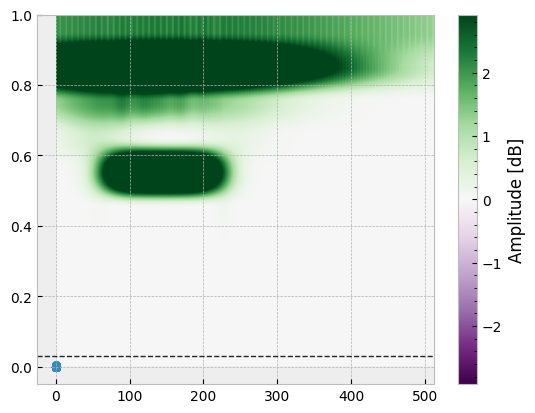

In [15]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(512)
y = np.sin(2*np.pi*x/32) + np.sin(2*np.pi*x/256)
for i in range(0, len(y)):
    if(i > 50 and i< 225):
        1
    else:
        y[i]=0
# plt.plot(x,y)

coef, freqs=pywt.cwt(y,[1, 2, 4, 8, 16, 32, 64, 128, 256, 512],'cmor1.5-1.0') # These frequencies are in Hertz!!!!!!!!
power = (abs(coef)) ** 2
im = plt.imshow(power, extent=[1, 512, 1/(512+1), 1], cmap='PRGn', aspect='auto',
           vmax=abs(coef).max(), vmin=-abs(coef).max(), origin='lower') 
print(coef)
print(coef.shape)
print(freqs)
print(power.shape)
plt.scatter(power[0], power[1])
cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()
plt.axhline(y=1/32, linestyle = 'dashed', linewidth=1, color='black', alpha=0.85) #adds black line @ y=0 Cut-off density!
plt.show() 



['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'shan', 'sym2', 'sym3

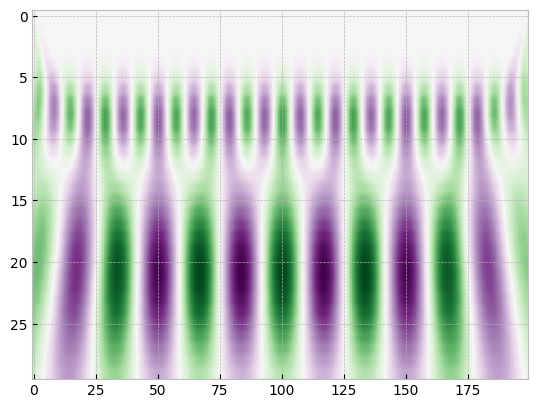

21.991148575128552
[[-0.00203388 -0.23066557  0.05094545 ... -0.00909677  0.06061184
  -0.23226332]
 [-0.01851609  0.65712726 -0.2840067  ... -0.15988436 -0.30826796
   0.65469027]
 [-0.04011228  0.9120732   0.5071549  ... -0.3852344   0.45633917
   0.94806868]
 ...
 [ 2.00857964  1.77279059  1.36573444 ...  0.2304229   0.60336555
   1.04726244]
 [ 1.71204678  1.50045857  1.12144522 ...  0.04062489  0.38325632
   0.79733719]
 [ 1.38081622  1.05644492  0.80986068 ... -0.26621178  0.11556212
   0.37285826]]
(30, 200)


In [16]:
import pywt
print(pywt.wavelist())
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + np.cos(2 * 3*np.pi * t)
# np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(sig, widths, 'gaus8')
plt.imshow(cwtmatr, cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  
cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()
plt.show() 
print(np.pi * 7)
print(cwtmatr)
print(cwtmatr.shape)

Widths = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512].


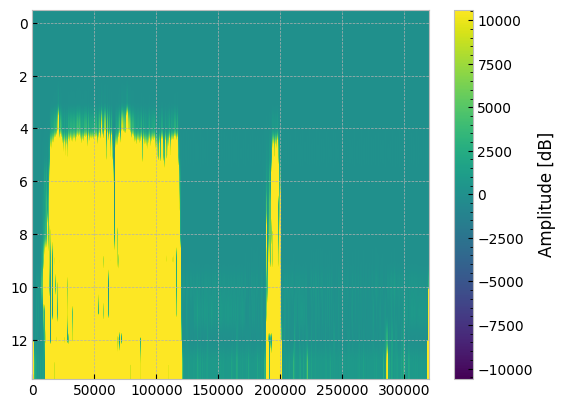

0.5
[8.000000e+00 4.000000e+00 2.000000e+00 1.000000e+00 5.000000e-01
 2.500000e-01 1.250000e-01 6.250000e-02 3.125000e-02 1.562500e-02
 7.812500e-03 3.906250e-03 1.953125e-03 9.765625e-04]


In [17]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

t = d['Coil2'][1]
sig  = d['Coil2'][0]

widths = []
for i in range(-4,10):
    widths.append(2**i)
print(f'Widths = {widths}.')

sampling_period = t[1] - t[0] # This is = 0.5. There's something wrong here... Check tomorrow!
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh', sampling_period)
power = (abs(cwtmatr)) ** 2

im = plt.imshow(power, cmap='viridis', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max()) 
           # 'vmax=abs(cwtmatr).max()' instead of 'vmax=abs(power).max()'?

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()

plt.show() # This is sort of similar to what we got before (using the STFT)!

f = pywt.scale2frequency('mexh', widths)/sampling_period
print(sampling_period)
print(f)

Widths = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512].


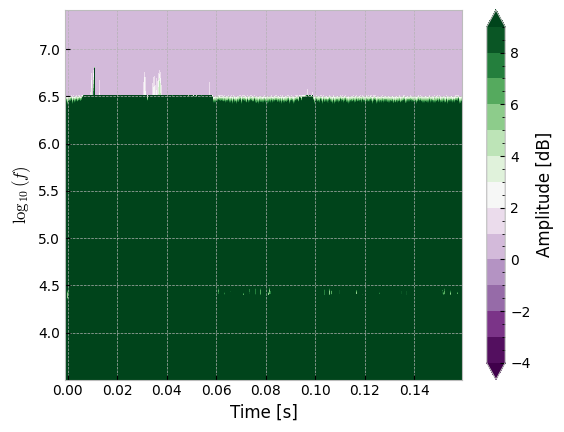

In [18]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

t = d['Coil2'][1]*1e-6
sampling_period = t[1] - t[0]

sig  = d['Coil2'][0]

widths = []
for i in range(-4,10):
    widths.append(2**i)
print(f'Widths = {widths}.')

[cwtmatr, freqs] = pywt.cwt(sig, widths, 'morl', sampling_period)
period = 1. / freqs
contourlevels = np.log2(widths)
power = (abs(cwtmatr)) ** 2

im = plt.contourf(t, np.log10(freqs), power, contourlevels, extend='both',cmap='PRGn')

plt.ylabel(r'$\log_{10}(f)$')
plt.xlabel('Time [s]')

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()

plt.show() # This is sort of similar to what we got before (using the STFT)!

Widths = [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048].
Normalized frequencies = [6.50000000e+06 3.25000000e+06 1.62500000e+06 8.12500000e+05
 4.06250000e+05 2.03125000e+05 1.01562500e+05 5.07812500e+04
 2.53906250e+04 1.26953125e+04 6.34765625e+03 3.17382812e+03
 1.58691406e+03 7.93457031e+02]
Sampling period = 5.000000000000664e-07


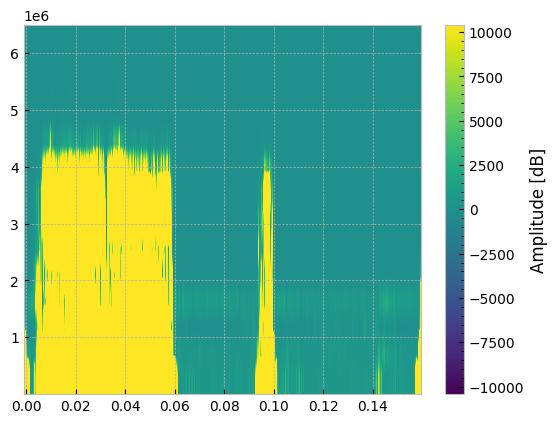

In [23]:
t = d['Coil2'][1]*1e-6
sig  = d['Coil2'][0]

widths = []
for i in range(-2,12):
    widths.append(2**i)
print(f'Widths = {widths}.')

sampling_period = t[1] - t[0] # This is = 0.5. There's something wrong here... Check tomorrow!
cwtmatr, freqs = pywt.cwt(sig, widths, 'morl', sampling_period)
power = (abs(cwtmatr)) ** 2

f = pywt.scale2frequency('morl', widths)/sampling_period
print(f'Normalized frequencies = {f}')
print(f'Sampling period = {sampling_period}')

im = plt.imshow(power, cmap='viridis', extent=[t[0], t[-1], f[-1], f[0]], aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max(), origin = 'upper') 
           # 'vmax=abs(cwtmatr).max()' instead of 'vmax=abs(power).max()'?

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()

plt.show() # This is sort of similar to what we got before (using the STFT)!


In [20]:
def plot_wavelet(ax, time2, signal, scales, waveletname = 'cmor', 
                 cmap =plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    dt=time2
    coefficients, frequencies = pywt.cwt(signal, scales, waveletname, dt)

    power = (abs(coefficients)) ** 2
    period = frequencies
    levels = [0.015625,0.03125,0.0625, 0.125, 0.25, 0.5, 1]
    contourlevels = np.log2(levels) #original
    time=range(2048)

    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)


    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))    
    ax.set_yticks(np.log2(yticks)) #original
    ax.set_yticklabels(yticks) #original
    ax.invert_yaxis()
    ylim = ax.get_ylim()

    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")

    return yticks, ylim

ValueError: x and y must have same first dimension, but have shapes (2048,) and (320512,)

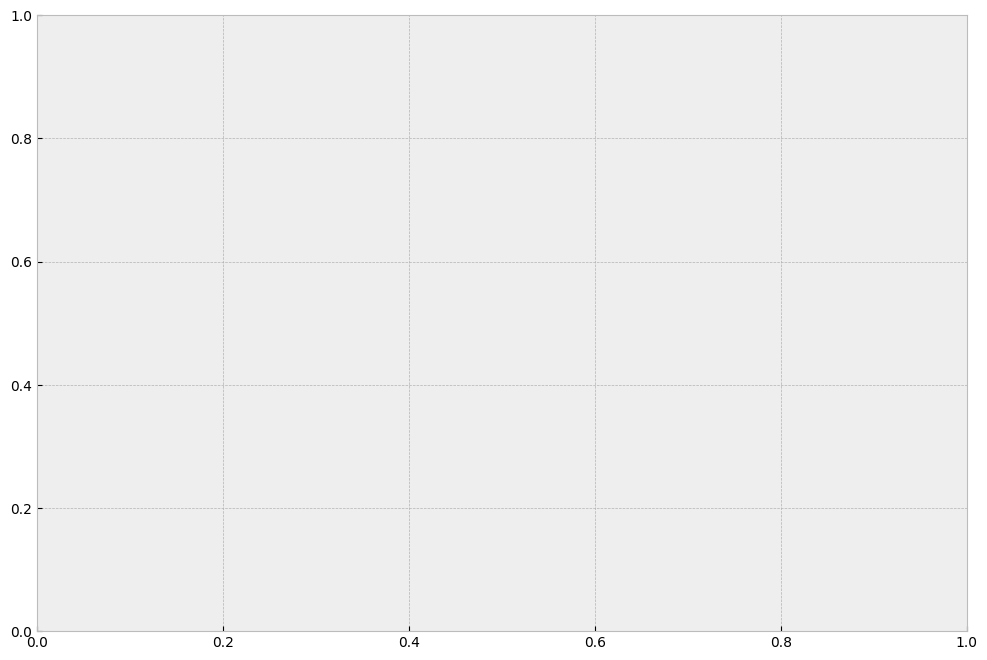

In [21]:
xrange=list(range(2048))
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(xrange,sig, color="b", alpha=0.5, label='original signal')
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.margins(0)
plt.show()


scale_range = np.arange(2, 50) # number of scales
fig, ax = plt.subplots(figsize=(12, 8))
plot_wavelet(ax=ax, time2=sampling_period, signal=sig, scales=scale_range,waveletname='cmor1.5-1.0',
             title = "CWT of Signal", ylabel = ylabel, xlabel = xlabel)
plt.show()

In [ ]:
def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor1.5-1.0', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")

    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(frequencies.min())), np.ceil(np.log2(frequencies.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    print(ylim)
    ax.set_ylim(ylim[0], ylim[1])
    return yticks, ylim

NameError: name 'plt' is not defined

In [ ]:
t = d['Coil2'][1]*1e-6
sig  = d['Coil2'][0]

widths = []
for i in range(-4,8):
    widths.append(2**i)
print(f'Widths = {widths}.')

sampling_period = t[1] - t[0]

scales = widths
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Frequency (Hz)'
xlabel = 'Time'

fig, ax = plt.subplots(figsize=(8, 6))
plot_wavelet(ax, t, sig, scales, xlabel=xlabel, ylabel=ylabel, title=title)
plt.show()

Widths = [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000].
